In [142]:
import json
import networkx as nx

program_name = "tcas3"

data = json.load(open(f"/home/vvejalla/centralized-localization/{program_name}_cfg_all_functions.json"))

graphs = []

node_to_lines_all = []

for entry in data:
    G = nx.DiGraph()
    node_to_lines = {}
    # edge from line i to line j iff there is a single block with i and j adjacent in the block 
    # or there are two blocks that are connected and 
    # Add nodes and their line mappings
    
    lines_set = set()
    
    
    for node, info in entry["nodes"].items():
        G.add_node(node)
        lines = info.get("lines", [])
        node_to_lines[node] = lines
        lines_set = lines_set.union(set(lines))

    # Add edges
    for edge in entry["edges"]:
        src, tgt = edge
        G.add_edge(src, tgt)
    
    H = nx.DiGraph()
    H.add_nodes_from(lines_set)
    for node in G.nodes:
        for i in range(1, len(node_to_lines[node])):
            H.add_edge(node_to_lines[node][i-1], node_to_lines[node][i])
    
    for edge in G.edges:
        if len(node_to_lines[edge[0]]) > 0 and len(node_to_lines[edge[1]]) > 0:
            H.add_edge(node_to_lines[edge[0]][-1], node_to_lines[edge[1]][0])
    

    graphs.append(H)
    # node_to_lines_all.append(node_to_lines)

In [143]:
graphs[0].nodes

NodeView(('tcas3.c:47', 'tcas3.c:82', 'tcas3.c:80', 'tcas3.c:91', 'tcas3.c:63', 'tcas3.c:70', 'tcas3.c:102', 'tcas3.c:106', 'tcas3.c:96', 'tcas3.c:73', 'tcas3.c:62', 'tcas3.c:112', 'tcas3.c:67', 'tcas3.c:104', 'tcas3.c:108', 'tcas3.c:116', 'tcas3.c:45', 'tcas3.c:110', 'tcas3.c:57', 'tcas3.c:59', 'tcas3.c:58', 'tcas3.c:114', 'tcas3.c:49', 'tcas3.c:60', 'tcas3.c:61', 'tcas3.c:85', 'tcas3.c:120', 'tcas3.c:46', 'tcas3.c:93', 'tcas3.c:75', 'tcas3.c:77', 'tcas3.c:53', 'tcas3.c:52', 'tcas3.c:124', 'tcas3.c:54', 'tcas3.c:78', 'tcas3.c:72', 'tcas3.c:66', 'tcas3.c:98', 'tcas3.c:44', 'tcas3.c:65', 'tcas3.c:42', 'tcas3.c:71', 'tcas3.c:125', 'tcas3.c:64', 'tcas3.c:55', 'tcas3.c:81', 'tcas3.c:68', 'tcas3.c:48', 'tcas3.c:87'))

In [144]:
import sys
import os

def parse_file(file):
    lookup = {}
    lines = file.readlines()
    for line in lines:
        splitted = line.strip().split(":", 2)
        if len(splitted) < 3:
            continue
        execs, line_no, statement = splitted
        execs = execs.strip()
        line_no = line_no.strip()
        statement = statement.strip()
        execs = execs.strip("*")
        execs = execs.strip()
        
        if not execs.isnumeric():
            continue
        if not line_no.isnumeric():
            raise Exception('weird line number')
        
        execs = int(execs)
        line_no = int(line_no)
        
        if execs <= 0:
            raise Exception('line executed 0 times')
        
        if line_no in lookup:
            raise Exception('repeated line number')
        
        lookup[line_no] = statement
    
    return lookup

passing_dir = f"coverage_output/{program_name}_passing"
failing_dir = f"coverage_output/{program_name}_failing"

counts = {}
statement_lookup = {}

total_failed = len(os.listdir(failing_dir))

for i,dir in [(0,passing_dir), (1,failing_dir)]:
    for gcov_file in os.listdir(dir):
        file_name = os.path.join(dir, gcov_file)
        file = open(file_name)
        lookup = parse_file(file)
        file.close()
        
        for line_no in lookup:
            if line_no not in counts:
                counts[line_no] = [0,0]
            
            counts[line_no][i] += 1
            
            if line_no in statement_lookup:
                assert statement_lookup[line_no] == lookup[line_no]
            else:
                statement_lookup[line_no] = lookup[line_no]

In [145]:
nodes = graphs[0].nodes
mapping = {node: int(node[node.find(":")+1:]) for node in nodes}

In [146]:
mapping

{'tcas3.c:47': 47,
 'tcas3.c:82': 82,
 'tcas3.c:80': 80,
 'tcas3.c:91': 91,
 'tcas3.c:63': 63,
 'tcas3.c:70': 70,
 'tcas3.c:102': 102,
 'tcas3.c:106': 106,
 'tcas3.c:96': 96,
 'tcas3.c:73': 73,
 'tcas3.c:62': 62,
 'tcas3.c:112': 112,
 'tcas3.c:67': 67,
 'tcas3.c:104': 104,
 'tcas3.c:108': 108,
 'tcas3.c:116': 116,
 'tcas3.c:45': 45,
 'tcas3.c:110': 110,
 'tcas3.c:57': 57,
 'tcas3.c:59': 59,
 'tcas3.c:58': 58,
 'tcas3.c:114': 114,
 'tcas3.c:49': 49,
 'tcas3.c:60': 60,
 'tcas3.c:61': 61,
 'tcas3.c:85': 85,
 'tcas3.c:120': 120,
 'tcas3.c:46': 46,
 'tcas3.c:93': 93,
 'tcas3.c:75': 75,
 'tcas3.c:77': 77,
 'tcas3.c:53': 53,
 'tcas3.c:52': 52,
 'tcas3.c:124': 124,
 'tcas3.c:54': 54,
 'tcas3.c:78': 78,
 'tcas3.c:72': 72,
 'tcas3.c:66': 66,
 'tcas3.c:98': 98,
 'tcas3.c:44': 44,
 'tcas3.c:65': 65,
 'tcas3.c:42': 42,
 'tcas3.c:71': 71,
 'tcas3.c:125': 125,
 'tcas3.c:64': 64,
 'tcas3.c:55': 55,
 'tcas3.c:81': 81,
 'tcas3.c:68': 68,
 'tcas3.c:48': 48,
 'tcas3.c:87': 87}

In [147]:
for i in range(len(graphs)):
    nodes = graphs[i].nodes
    mapping = {node: int(node[node.find(":")+1:]) for node in nodes}
    graphs[i] = nx.relabel_nodes(graphs[i], mapping)

In [148]:
for i in range(len(graphs)):
    for node in graphs[i]:
        if node in counts:
            if counts[node][0] + total_failed - counts[node][1] == 0:
                graphs[i].nodes[node]["score"] = counts[node][1]**2/0.5
            else:
                graphs[i].nodes[node]["score"] = counts[node][1]**2/(counts[node][0] + total_failed - counts[node][1])
            graphs[i].nodes[node]["passing"] = counts[node][0]
            graphs[i].nodes[node]["failing"] = counts[node][1]
        else:
            graphs[i].nodes[node]["score"] = 0
            graphs[i].nodes[node]["passing"] = 0
            graphs[i].nodes[node]["failing"] = 0

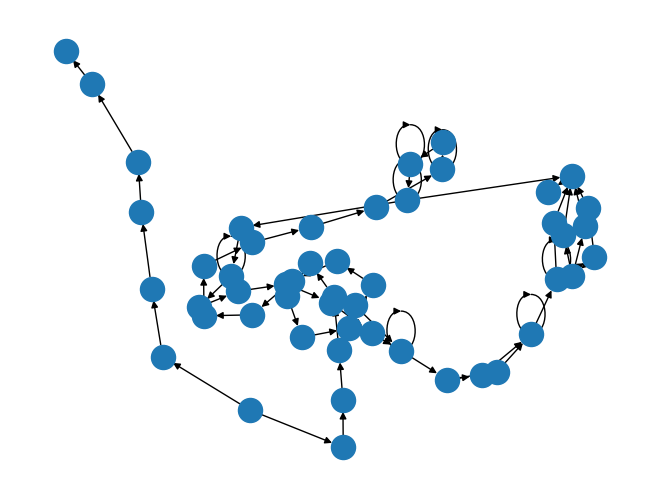

In [149]:
nx.draw(graphs[0])

In [150]:
import numpy as np

In [151]:
def inverse_sqrt_degree_matrix(D):
    d = np.diag(D)
    d_inv_sqrt = np.zeros_like(d)
    nonzero_mask = d > 0
    d_inv_sqrt[nonzero_mask] = 1.0 / np.sqrt(d[nonzero_mask])
    return np.diag(d_inv_sqrt)

In [152]:
graph = graphs[0]


index_to_line = list(graph.nodes)
suspiciousness = [graph.nodes[index_to_line[i]]["score"] for i in range(len(index_to_line))]
line_to_index = {}
for i, line in enumerate(index_to_line):
    line_to_index[line] = i

suspiciousness = np.array(suspiciousness).reshape((-1,1))
adjacency_matrix = np.zeros((len(index_to_line), len(index_to_line)))

for edge in graph.edges:
    adjacency_matrix[line_to_index[edge[0]], line_to_index[edge[1]]] = 1

adj_matrix = adjacency_matrix.copy()

for i in range(adjacency_matrix.shape[0]):
    if adj_matrix[i].sum() == 0:
        adj_matrix[i][i] = 1

adj_matrix/= adj_matrix.sum(axis=1,keepdims=1)

alpha = 0.5
flow = (1-alpha)*suspiciousness + alpha*adj_matrix@suspiciousness

augmented = adjacency_matrix + np.eye(adjacency_matrix.shape[0])
D_in = np.diag(np.sum(augmented, axis=0))
D_out = np.diag(np.sum(augmented, axis=1))

in_suspiciousness = inverse_sqrt_degree_matrix(D_in) @ augmented @ inverse_sqrt_degree_matrix(D_in) @ suspiciousness
out_suspiciousness = inverse_sqrt_degree_matrix(D_out) @ augmented @ inverse_sqrt_degree_matrix(D_out) @ suspiciousness

In [153]:
centrality = nx.in_degree_centrality(graph)
for node in graph.nodes:
    centrality[node] *= graph.nodes[node]["score"]

In [ ]:
import numpy as np
import networkx as nx

def get_rank_bounds(score_list, target_node):
    score_list.sort(key=lambda s: (-s[0], s[1]))  # sort descending, then by node id
    target_score = None
    for score, node in score_list:
        if node == target_node:
            target_score = score
            break
    min_rank = float('inf')
    max_rank = -1
    for i, (score, node) in enumerate(score_list):
        if abs(score - target_score) < 1e-6:
            min_rank = min(min_rank, i)
            max_rank = max(max_rank, i)
    return min_rank, max_rank

# Mapping from node index to id
index_to_line = list(graph.nodes)
line_to_index = {line: i for i, line in enumerate(index_to_line)}

# Convert suspiciousness-related vectors to dicts
suspiciousness_vec = suspiciousness.flatten()
flow_vec = flow.flatten()
in_susp_vec = in_suspiciousness.flatten()
out_susp_vec = out_suspiciousness.flatten()

suspiciousness_dict = {index_to_line[i]: suspiciousness_vec[i] for i in range(len(index_to_line))}
flow_dict = {index_to_line[i]: flow_vec[i] for i in range(len(index_to_line))}
in_susp_dict = {index_to_line[i]: in_susp_vec[i] for i in range(len(index_to_line))}
out_susp_dict = {index_to_line[i]: out_susp_vec[i] for i in range(len(index_to_line))}

# Centralities
in_deg_centrality = nx.in_degree_centrality(graph)
out_deg_centrality = nx.out_degree_centrality(graph)
pagerank_centrality = nx.pagerank(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
# eigenvector_centrality = nx.eigenvector_centrality(graph)
closeness_centrality = nx.closeness_centrality(graph)

# Multiply node scores by centralities
def weighted_centrality(centrality_dict):
    return {node: graph.nodes[node]["score"] * centrality_dict.get(node, 0) for node in graph.nodes}

metrics = {
    "suspiciousness": suspiciousness_dict,
    "flow": flow_dict,
    "in_suspiciousness": in_susp_dict,
    "out_suspiciousness": out_susp_dict,
    "in_deg_centrality": weighted_centrality(in_deg_centrality),
    "out_deg_centrality": weighted_centrality(out_deg_centrality),
    "pagerank_centrality": weighted_centrality(pagerank_centrality),
    "betweenness_centrality": weighted_centrality(betweenness_centrality),
    "closeness_centrality": weighted_centrality(closeness_centrality),
    # "eigenvector_centrality": weighted_centrality(eigenvector_centrality),
}

actual_bad_line = 102

# Compute and print rank bounds for each metric
for name, score_dict in metrics.items():
    L = [(score_dict[node], node) for node in graph.nodes]
    min_rank, max_rank = get_rank_bounds(L, actual_bad_line)
    print(f"{name}: min_rank = {min_rank+1}, max_rank = {max_rank+1}")


suspiciousness: min_rank = 0, max_rank = 1
flow: min_rank = 0, max_rank = 1
in_suspiciousness: min_rank = 2, max_rank = 3
out_suspiciousness: min_rank = 0, max_rank = 1
in_deg_centrality: min_rank = 5, max_rank = 6
out_deg_centrality: min_rank = 9, max_rank = 10
pagerank_centrality: min_rank = 9, max_rank = 9
betweenness_centrality: min_rank = 20, max_rank = 20
closeness_centrality: min_rank = 0, max_rank = 0
